In [6]:
import array

a = array.array('i',[2,4,5])

In [8]:
a[0:2]

array('i', [2, 4])

In [9]:
a.append(4)

In [10]:
a

array('i', [2, 4, 5, 4])

In [12]:
a.pop(2)

5

In [13]:
a

array('i', [2, 4, 4])

In [18]:
memory = array.array('i')
memory

array('i')

In [19]:
memory.append(4)
memory

array('i', [4])

In [21]:
import random
random.choice(a)

4

In [22]:
a

array('i', [2, 4, 4])

In [45]:
random.randint(0,0)

0

In [49]:
import array
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import timeit
import random
import seaborn as sns
sns.set()


class memory_cell():
    """
    Memory cell to store the impression of another agent is simply its defection rate
    
    Attributes
    ------------
    defect_number_ : Number of defection
    play_number_   : Number of Plays
    
    """
    def __init__(self, act = 'C'):
        self.defect_number_ = 0
        self.play_number_ = 1
        
        if act == 'D' : self.defect_number_ += 1
    
    def update(self, act):
        if act == 'D' : self.defect_number_ += 1
        self.play_number_ += 1
    
    def impression(self):
        return self.defect_number_/max(1, self.play_number_)
    
class agent():
    """
    Player of a Prisoners Dilemma Game. 
    
    Parameters
    ------------
    ID            : Unique identifier for the agent
    pd            : Probability of defection
    capacity      : Memory Size/Capacity 
    
        
    Attributes
    ------------
    score_                  : Accumulates payoffs (define success/fitness)
    memory_for_defectors_   : 
    memory_for_cooperators_ :
                 Store information about a limited number (M) of opponent players.
                 Dictionary (key, value) = (other_agent, memory_cell)
    defector_list_          :
    cooperator_list_        :
    
    """
    def __init__(self, ID, pd = 1, M = 1):
        self.ID = ID
        self.pd = pd
        self.capacity = M
        self.score_ = 0
        
        self.memory_for_defectors_ = dict()
        self.memory_for_cooperators_ = dict()
        
        self.defector_array_ = array.array('i')
        self.cooperator_array_ = array.array('i')
        
    def act(self):
        """
        Two possible actions
            - defect with probability pd
            - cooperate with probability 1 - pd
        """
        if np.random.rand() < self.pd:
            return 'D'
        return 'C'
    
    def know(self, other):
        return (other.ID in self.memory_for_defectors_) or (other in self.memory_for_cooperators_)
    
    def is_memory_full(self):
        c,d = len(self.memory_for_cooperators_), len(self.memory_for_defectors_)
        return  c + d >= self.capacity
    
    def perceive_as_defector(self, other):
        return other.ID in self.memory_for_defectors_
    
    def take_payoff(self, payoff):
        self.score_ += payoff
    
    def learn(self, other, act):  
        if other.ID in self.memory_for_defectors_:
            print("-- Bug -- Dont play with a defector!! -- ")
        elif other.ID in self.memory_for_cooperators_:
            self.memory_for_cooperators_[other.ID].update(act)
            
            # a cooperator became a defector!
            if self.memory_for_cooperators_[other.ID].impression() > 0.5:
                self.memory_for_defectors_[other.ID] = self.memory_for_cooperators_[other.ID]
                del self.memory_for_cooperators_[other.ID]
                
                # !! I forget to implement this code at the begining
                self.cooperator_array_.remove(other.ID)
                self.defector_array_.append(other.ID)
                
        else: # first play with an unknown player
            if self.is_memory_full(): 
                self.forget()
            if act == 'C':
                self.memory_for_cooperators_[other.ID] = memory_cell(act)
                self.cooperator_array_.append(other.ID)
            else:
                self.memory_for_defectors_[other.ID] = memory_cell(act)
                self.defector_array_.append(other.ID)
        
    def forget(self):   
        if len(self.memory_for_cooperators_) > 0:
            f = random.randint(0,len(self.cooperator_array_)-1)
            ID = self.cooperator_array_.pop(f)
            del self.memory_for_cooperators_[ID]
        elif len(self.memory_for_defectors_) > 0:
            f = random.randint(0,len(self.defector_array_)-1)
            ID = self.defector_array_.pop(f)
            del self.memory_for_defectors_[ID]

    def display(self):
        return [(k, v.impression()) for (k,v) in self.memory_for_cooperators_.items()] + [(k, v.impression()) for (k,v) in self.memory_for_defectors_.items()]
    
    

In [50]:
class abm():
    def __init__(self, N = 10, M = 9, tau = 5, payoff = {'CC':3,'CD':0,'DC':5,'DD':1}):
        self.N = N
        self.time = self.N * self.N * tau
        self.population = [agent(i, pd = np.random.rand(), M = M) for i in range(self.N)]
        self.payoff = payoff
        
    def world(self):
        for i in range(self.time):
            iA, iB = np.random.choice(range(self.N), 2, replace=False)
            A, B = self.population[iA], self.population[iB]
            
            # Decision to interact
            if B.perceive_as_defector(A): continue
            if A.perceive_as_defector(B): continue
            
            A_action, B_action = A.act(), B.act()
            A.learn(B, B_action)
            B.learn(A, A_action)

            A.take_payoff(self.payoff[A_action+B_action])
            B.take_payoff(self.payoff[B_action+A_action])
            
    def display(self):
        df = pd.DataFrame(columns=['ID','pD', 'score', 'M', 'Memory Len', 'Memory'])
        for A in self.population:
            df.loc[A.ID] = pd.Series({'ID':A.ID, 'pD':A.pd, 'score':A.score_, 'M': A.capacity, 
                                      'Memory Len': len(A.memory_for_cooperators_) + len(A.memory_for_defectors_), 
                                      'Memory':A.display()})
        return df

# Simulation

In [51]:
N = 100
M = 50
sim = abm(N, M)
sim.world()
result = sim.display()
result.head(3)

,ID,pD,score,M,Memory Len,Memory
0,0,0.322070,656,50,50,"[(85, 1.0), (91, 1.0), (40, 1.0), (74, 1.0), (..."
1,1,0.049905,810,50,50,"[(36, 0.0), (20, 1.0), (60, 1.0), (35, 1.0), (..."
2,2,0.279968,625,50,50,"[(54, 1.0), (15, 1.0), (57, 1.0), (84, 1.0), (..."


In [52]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 6 columns):
ID            100 non-null object
pD            100 non-null float64
score         100 non-null object
M             100 non-null object
Memory Len    100 non-null object
Memory        100 non-null object
dtypes: float64(1), object(5)
memory usage: 5.5+ KB


# Data Analysis

In [53]:
def makeDict(T):
    return {t[0]:t[1] for t in T}

data = list(result.Memory.apply(makeDict))
df = pd.DataFrame(data).fillna(0)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


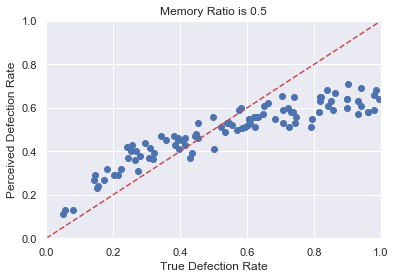

In [54]:
perception = df.mean(axis = 0)
plt.plot(result.pD[perception.index] , perception, 'o')
plt.xlabel('True Defection Rate')
plt.ylabel('Perceived Defection Rate')
plt.title("Memory Ratio is {}".format(M/N))
plt.plot([0, 1], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.show()

# Do Some Analysis

In [55]:
import time
start = time.time()

N = 100
Ms = [5, 25, 50, 75, 85, 99]
results = []
dfs = []

for M in Ms:
    sim = abm(N, M)
    sim.world()
    result = sim.display()
    results.append(result)
    
    data = list(result.Memory.apply(makeDict))
    df = pd.DataFrame(data).fillna(0)
    dfs.append(df)
    
end = time.time()
print(end - start)

12.903059959411621


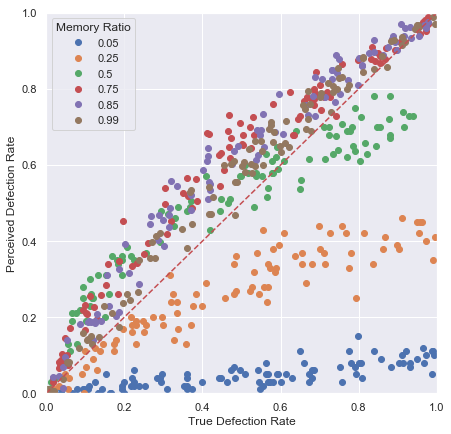

In [56]:
plt.figure(figsize = (7,7))
for k in range(len(Ms)):
    perception = dfs[k].mean(axis = 0)
    result = results[k]
    plt.plot(result.pD[perception.index] , perception, 'o')
    plt.xlabel('True Defection Rate')
    plt.ylabel('Perceived Defection Rate')
plt.legend(np.array(Ms)/N,title = "Memory Ratio")

plt.plot([0, 1], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.show()

In [9]:
a1,a2 = memory_cell(), memory_cell()

In [11]:
A = np.array([a1,a2])